# ML Micro Project: Flood Prediction
- 환경 및 사회경제적 변수를 통해 홍수발생예측
- 데이터: Kaggle https://www.kaggle.com/datasets/naiyakhalid/flood-prediction-dataset

- 문제정의: 환경 변수와 사회경제적 변수를 통해 홍수발생예측

- 분석방법과 이유: 회귀분석을 사용했으며 다양한 회귀모델을 통해 홍수발생예측에 가장 적합한 모델을 찾는 것을 목표로함. 회귀분석을 사용하는 이유는 예측값인 종속변수가 연속적인 값(0~1 사이)이기 때문이고, 독립변수들과 종속변수 간의 관계성을 설명하기에 용이하기 때문

- 결론 및 시사점: XGBRegressor, LGBMRegressor 모델이 예측에 가장 높은 성능을 보였음. 그러나 데이터의 단순함으로 인해 추가적인 분석을 하기에 한계가 있다고 판단함. 이를 보완하는 방법으로는 1.홍수는 시간에 따른 변동성을 가진 현상이므로 시계열 분석 2.데이터 증강 3.목표변수들 끼리도 상관관계가 존재할 수 있으므로 상호작용 피쳐 등 추가 특징을 생성

#### Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
%pip install xgboost
from xgboost import XGBRegressor
%pip install lightgbm
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Reading the Data

In [4]:
df = pd.read_csv('flood.csv')
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


#### 데이터 모양 확인
- null 값이 없음
- 모든 피쳐가 int값
- floodprobability 변수: target

#### 데이터 설명
홍수 발생 및 심각도에 영향을 미치는 환경과 인적 요인에 대한 데이터 셋으로 구성되어 있음
1. MonsoonIntensity: 몬순 기간 동안 강우량이 많으면 홍수 가능성이 커짐
2. TopographyDrainage: 지역 지형에 따른 배수 
3. RiverManagement: 강 관리 관행의 질과 효과  
4. Deforestation: 해당 지역의 삼림 벌채 범위  
5. Urbanization: 해당 지역의 도시화 수준
6. ClimateChange: 해당 지역에 미치는 기후 변화의 영향
7. DamsQuality     
8. Siltation: 강과 저수지의 침적 정도로 강에 퇴적물이 축적되면 홍수위험 증가
9. AgriculturalPractices 
10. Encroachments: 홍수 평야와 자연 수로의 침범 정도로 홍수발생위험 지역에 건설시 홍수 위험이 커짐
11.  IneffectiveDisasterPreparedness
12.  DrainageSystems
13.  CoastalVulnerability  
14.  Landslides     
15.  Watersheds: 유역이 많은 지역은 요인에 따라 홍수 위험성의 정도가 달라짐  
16.  DeterioratingInfrastructure  
17.  PopulationScore: 인구밀도     
18.  WetlandLoss                
19.  InadequatePlanning           
20.  FloodProbability: 타겟변수            

In [5]:
print(df.shape)
print(df.info())

(50000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization                     50000 non-null  int64  
 5   ClimateChange                    50000 non-null  int64  
 6   DamsQuality                      50000 non-null  int64  
 7   Siltation                        50000 non-null  int64  
 8   AgriculturalPractices            50000 non-null  int64  
 9   Encroachments                    50000 non-null  int64  
 10  IneffectiveDisasterPreparedness  50000 non-null  int64  
 11  DrainageSystems                  50000 non-null  int64  
 12  Coasta

In [6]:
#max값이 변수마다 상이함
df.describe()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,4.991480,4.984100,5.01594,5.008480,4.989060,4.988340,5.01536,4.988600,5.006120,5.006380,...,5.006060,4.999920,4.984220,4.97982,4.988200,4.984980,5.00512,4.994360,4.990520,0.499660
std,2.236834,2.246488,2.23131,2.222743,2.243159,2.226761,2.24500,2.232642,2.234588,2.241633,...,2.238107,2.247101,2.227741,2.23219,2.231134,2.238279,2.23176,2.230011,2.246075,0.050034
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.285000
25%,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.00000,3.000000,3.000000,0.465000
50%,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.00000,5.000000,5.000000,0.500000
75%,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.00000,6.000000,6.000000,0.535000
max,16.000000,18.000000,16.00000,17.000000,17.000000,17.000000,16.00000,16.000000,16.000000,18.000000,...,17.000000,17.000000,16.000000,16.00000,17.000000,19.000000,22.00000,16.000000,16.000000,0.725000


#### EDA
- target 변수의 분포 및 다른 변수들의 분포 확인

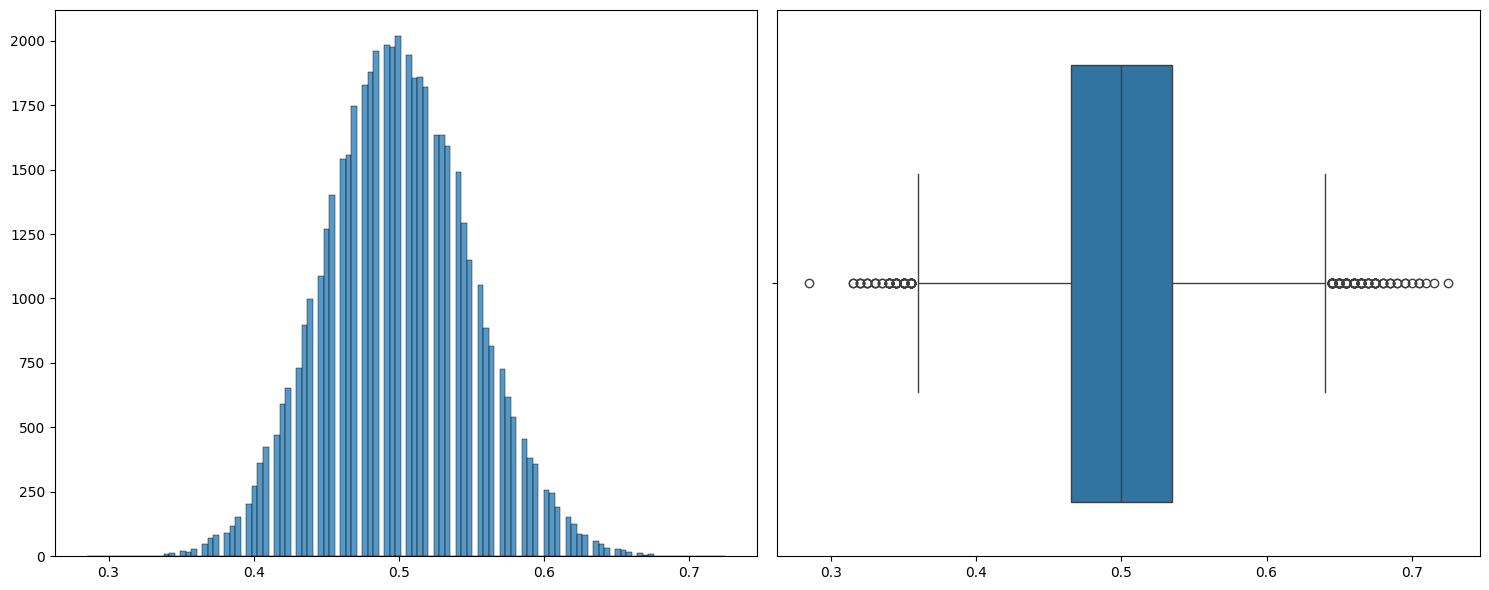

In [7]:
# floodprobability
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

sns.histplot(df, x=df.columns[-1], ax=axes[0])
axes[0].set_ylabel('')
axes[0].set_xlabel('')

sns.boxplot(df, x=df.columns[-1], ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show();

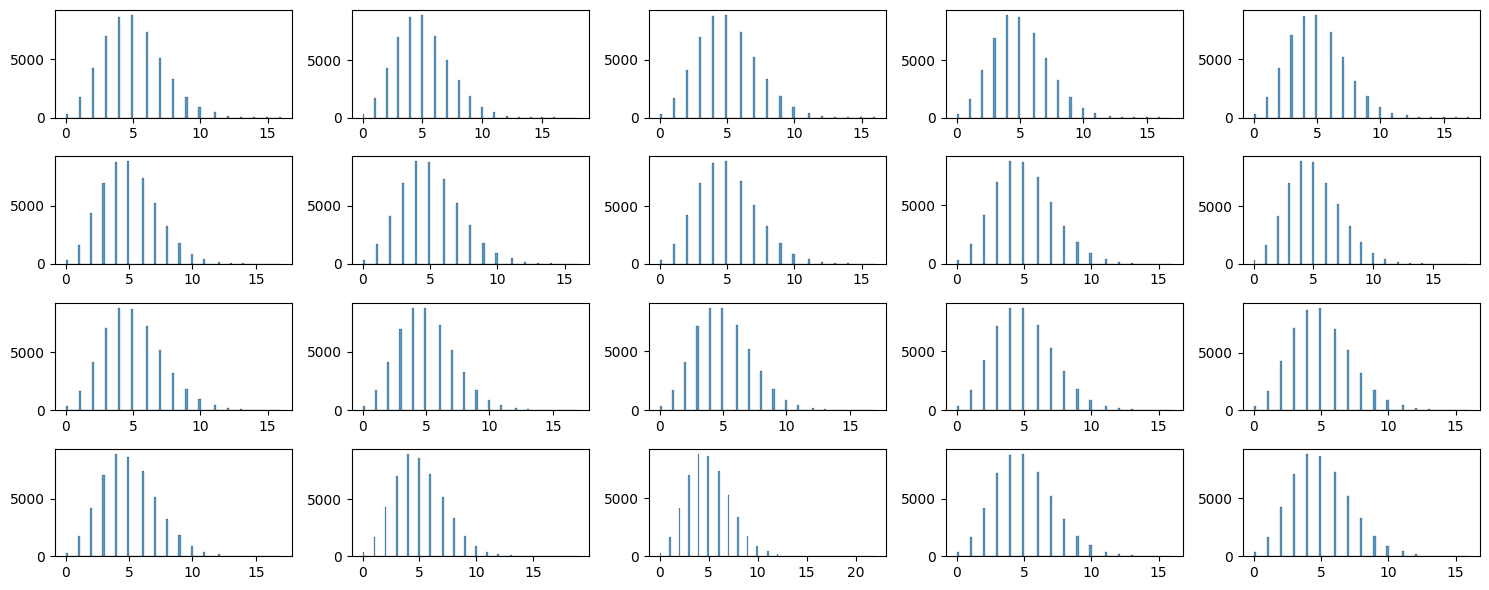

In [8]:
# 변수 분포
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,6))

index = 0

for i in range(4):
    for j in range(5):
        sns.histplot(df, x=df.columns[index], ax=axes[i][j])
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        index += 1

plt.tight_layout()
plt.show()

- target 변수와 두드러지게 상관관계가 있는 변수는 보이지 않음

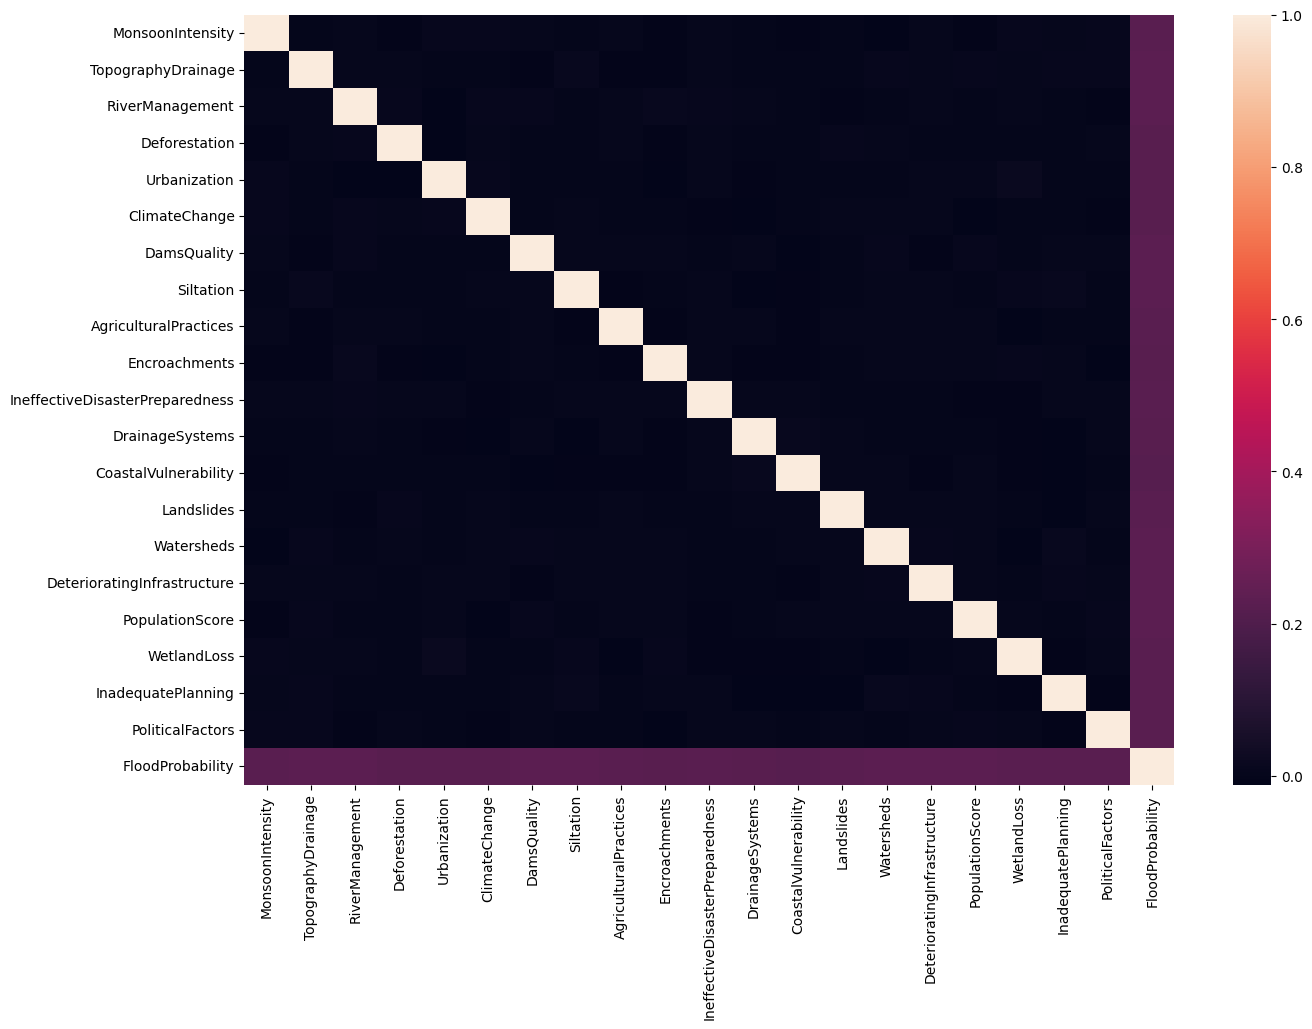

In [9]:
# 변수간 상관관계
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=False)
plt.show()

#### Preprocessing
- minmax 스케일링의 이유: 범주형 데이터가 따로 없어 스케일링을 하지 않아도 되지만 변수간 min값과 max값이 상이하기 때문에 표준화 진행

In [11]:
# Scaling features
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

scaler = MinMaxScaler()

x = scaler.fit_transform(x)

#### Modeling
- 홍수 발생 확률변수와 관련있는 변수들을 바탕으로 발생 확률을 예측해야하므로 회귀분석 진행

In [13]:
def evaluate_models(X, y):
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 리스트
    models = {
        'RandomForestRegressor': RandomForestRegressor(),
        'AdaBoostRegressor': AdaBoostRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'ExtraTreesRegressor': ExtraTreesRegressor(),
        'LinearRegression': LinearRegression(),
        'SVR': SVR(),
        'XGBRegressor': XGBRegressor(),
        'LGBMRegressor': LGBMRegressor()
    }

       # 모델 성능 저장을 위한 리스트
    results = []

    # 모델 학습 및 평가
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append({'Model': name, 'MSE': mse, 'R2': r2})
        print(f'{name} - MSE: {mse}, R2: {r2}')
    
    # 모델 성능 시각화
    results_df = pd.DataFrame(results)
    plot_results(results_df)

def plot_results(results_df):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # MSE 바 차트
    results_df.plot(kind='bar', x='Model', y='MSE', ax=ax[0], legend=False, color='skyblue')
    ax[0].set_title('Mean Squared Error (MSE) of Models')
    ax[0].set_ylabel('MSE')

    # R2 바 차트
    results_df.plot(kind='bar', x='Model', y='R2', ax=ax[1], legend=False, color='lightgreen')
    ax[1].set_title('R-squared (R2) of Models')
    ax[1].set_ylabel('R2')

    plt.tight_layout()
    plt.show()

RandomForestRegressor - MSE: 0.0006736188090000003, R2: 0.7295339818392469
AdaBoostRegressor - MSE: 0.0008824381469144782, R2: 0.6456905171287869
GradientBoostingRegressor - MSE: 0.0005505254200461403, R2: 0.7789574515040664
ExtraTreesRegressor - MSE: 0.0006638014717500004, R2: 0.733475760304267
LinearRegression - MSE: 1.1059860706077696e-31, R2: 1.0
SVR - MSE: 0.0006971301967531037, R2: 0.7200938781158139
XGBRegressor - MSE: 0.00018627406166298944, R2: 0.9252087336762307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 20
[LightGBM] [Info] Start training from score 0.499519
LGBMRegressor - MSE: 0.000191909843001507, R2: 0.9229458999823253


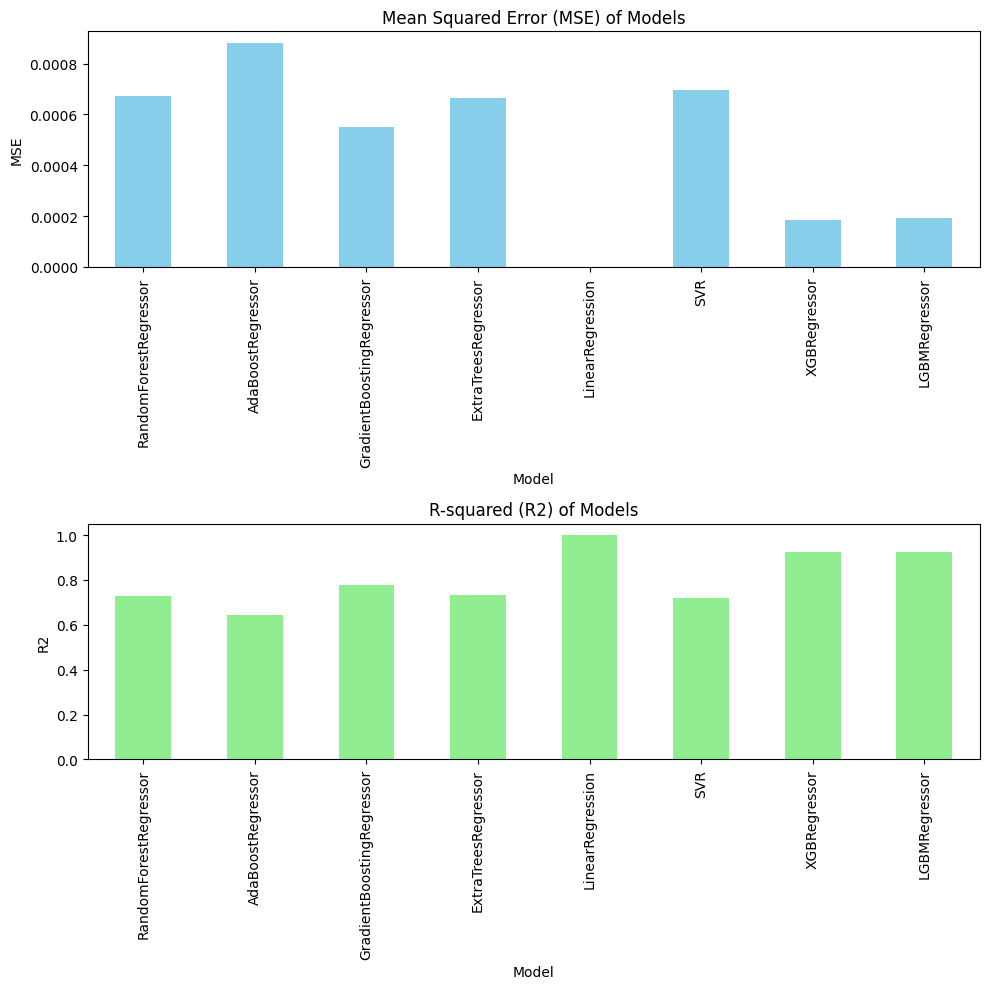

In [14]:
# 데이터 분리
X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']

# 모델 평가 함수 호출
evaluate_models(X, y)